In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# from keras.models import Sequential
# from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity

# Comparison between _model.fit()_ and _GradientTape_ methods:
Using _MNIST_ dataset

### Load and prepare the MNIST dataset:

In [2]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 28, 28

In [3]:
batch_size = 32
num_classes = 10
epochs = 50

In [4]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [6]:
# Add a channels dimension
# X_train = X_train[..., tf.newaxis]
# X_test = X_test[..., tf.newaxis]

if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (28, 28, 1)



In [7]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (60000, 28, 28, 1), y_train = (60000, 10)
X_test.shape = (10000, 28, 28, 1), y_test = (10000, 10)


In [9]:
# Use tf.data to batch and shuffle the dataset-

train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(10000).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)).batch(batch_size)

In [10]:
def create_cnn():
    """
    Function to create a simple
    CNN for MNIST classification
    """
    
    model = Sequential()
    
    model.add(
        Conv2D(
            filters = 32, kernel_size = (3, 3),
            activation = 'relu',
            kernel_initializer = tf.keras.initializers.GlorotNormal(),
            input_shape = (28, 28, 1)
        )
    )
    
    model.add(
        Flatten()
    )
    
    model.add(
        Dense(
            units = 128, activation = 'relu',
            kernel_initializer = tf.keras.initializers.GlorotNormal()
        )
    )
    
    model.add(
        Dense(
            units = 10, activation = 'softmax'
        )
    )
    
    return model
    
    

### First, _model.fit()_ is used:

In [11]:
# Instantiate an instance of CNN-
model = create_cnn()

In [12]:
# Save weights to be reused by 'GradientTape' model later-
model.save_weights("Random_Weights.h5", overwrite=True)

In [13]:
# Compile the designed nn model-
model.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr = 0.001),
    metrics=['accuracy']
)

In [14]:
# Define early stopping-
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3,
    min_delta = 0.001, mode = 'min'
)

In [15]:
# Get summary details of defined model-
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2769024   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Train defined model-
history_orig = model.fit(
    x = X_train, y = y_train,
    batch_size = batch_size, epochs = epochs,
    validation_data = (X_test, y_test),
    callbacks = [callback],
    verbose = 1
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 20s 338us/sample - loss: 0.1319 - accuracy: 0.9595 - val_loss: 0.0576 - val_accuracy: 0.9814
Epoch 2/50
60000/60000 [==============================] - 19s 320us/sample - loss: 0.0414 - accuracy: 0.9872 - val_loss: 0.0526 - val_accuracy: 0.9818
Epoch 3/50
60000/60000 [==============================] - 19s 318us/sample - loss: 0.0216 - accuracy: 0.9933 - val_loss: 0.0521 - val_accuracy: 0.9844
Epoch 4/50
60000/60000 [==============================] - 19s 314us/sample - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.0597 - val_accuracy: 0.9825
Epoch 5/50
60000/60000 [==============================] - 19s 312us/sample - loss: 0.0099 - accuracy: 0.9967 - val_loss: 0.0561 - val_accuracy: 0.9848


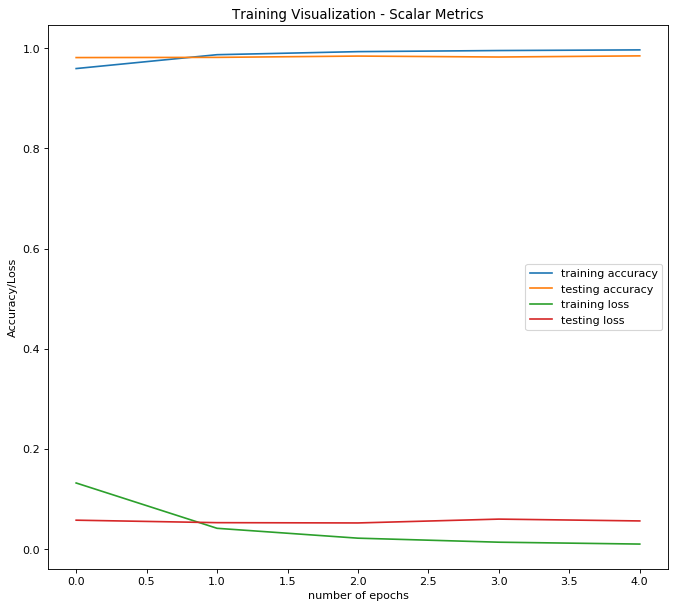

In [17]:
# Visualize training progress of neural network model-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_orig.history['accuracy'], label = 'training accuracy')
plt.plot(history_orig.history['val_accuracy'], label = 'testing accuracy')
plt.plot(history_orig.history['loss'], label = 'training loss')
plt.plot(history_orig.history['val_loss'], label = 'testing loss')

plt.title("Training Visualization - Scalar Metrics")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc = 'best')
plt.show()


In [18]:
score_orig = model.evaluate(X_test, y_test, verbose=0)

In [19]:
print("\n'model.fit()' metrics on testing set:")
print("loss = {0:.4f} & accuracy = {1:.4f}\n".format(
    score_orig[0], score_orig[1]))


'model.fit()' metrics on testing set:
loss = 0.0561 & accuracy = 0.9848



In [20]:
# Make predictions using trained model-
y_pred_orig = model.predict_classes(X_test)

In [21]:
# Convert from one-hot encoded to labels-
y_test_labels = np.argmax(y_test, axis=1)

In [22]:
# Compute metrics-
accuracy_orig = accuracy_score(y_test_labels, y_pred_orig)
precision_orig = precision_score(y_test_labels, y_pred_orig, average='macro')
recall_orig = recall_score(y_test_labels, y_pred_orig, average='macro')

In [23]:
print("\n'model.fit()' metrics on testing dataset are:")
print("accuracy = {0:.4f}, precision = {1:.4f} & recall = {2:.4f}\n".format(
    accuracy_orig, precision_orig, recall_orig))


'model.fit()' metrics on testing dataset are:
accuracy = 0.9848, precision = 0.9847 & recall = 0.9848



In [24]:
print("\n'model.fit()' confusion matrix:\n")
print(confusion_matrix(y_test_labels, y_pred_orig))


'model.fit()' confusion matrix:

[[ 971    0    2    0    0    0    4    1    2    0]
 [   1 1126    2    0    1    0    3    1    1    0]
 [   2    3 1016    1    1    0    0    3    6    0]
 [   0    0    5  990    0    8    0    5    2    0]
 [   0    0    1    0  969    0    3    0    1    8]
 [   2    1    1    3    0  879    6    0    0    0]
 [   3    2    1    0    2    2  948    0    0    0]
 [   1    1    7    0    1    0    0 1010    4    4]
 [   2    1    3    1    0    2    3    4  955    3]
 [   4    3    0    0    5    6    1    3    3  984]]


### Now, _GradientTape_ is used:

In [48]:
# Instantiate a model-
model_gt = create_cnn()

In [49]:
# Restore random weights as used by the previous model for fair comparison-
model_gt.load_weights("Random_Weights.h5")

In [50]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.001)

In [51]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

In [52]:
# Use tf.GradientTape to train the model-

@tf.function
def train_step(data, labels):
    """
    Function to perform one step of Gradient
    Descent optimization
    """

    with tf.GradientTape() as tape:
        predictions = model_gt(data)
        loss = loss_fn(labels, predictions)

    gradients = tape.gradient(loss, model_gt.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_gt.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

    

In [53]:
@tf.function
def test_step(data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model_gt(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


In [54]:
# User input-
minimum_delta = 0.001
patience = 3

patience_val = np.zeros(patience)

In [55]:
# Dictionary to hold scalar metrics-
history = {}

history['accuracy'] = np.zeros(epochs)
history['val_accuracy'] = np.zeros(epochs)
history['loss'] = np.zeros(epochs)
history['val_loss'] = np.zeros(epochs)

### Logic behind manual _EarlyStopping_:
_check = np.diff(history['val_loss'][epoch - 3:epoch], n = 1) > minimum_delta_ checks whether the absolute value of the consecutive differences between the last 3 epoch's _validation loss_ is more than _minimum delta_

1. _Case - 1:_ If any of these absolute values of the consecutive differences is _greater than_ _min_delta_, then __keep training__

1. _Case - 2_: If all of these absolute values of the consecutive differences is _less than_ _min_delta_, then __Stop training__

In [56]:
for epoch in range(epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for x, y in train_ds:
        train_step(x, y)

    for x_t, y_t in test_ds:
        test_step(x_t, y_t)

    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'

    history['accuracy'][epoch] = train_accuracy.result()
    history['loss'][epoch] = train_loss.result()
    history['val_loss'][epoch] = test_loss.result()
    history['val_accuracy'][epoch] = test_accuracy.result()

    print(template.format(epoch + 1, 
                          train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))

    if epoch > 2:
        # Computes absolute differences between 3 consecutive loss values-
        differences = np.abs(np.diff(history['val_loss'][epoch - patience:epoch], n = 1))
        print("differences: {0}".format(differences))
        
        # Checks whether the absolute differences is greater than 'minimum_delta'-
        check =  differences > minimum_delta
        print("check = {0}\n".format(check))
        
        if np.all(check == False):
            print("\n\nEarlyStopping Evoked! Stopping training\n\n")
            break



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.1353, Accuracy: 99.2113, Test Loss: 0.0588, Test Accuracy: 99.610947
Epoch 2, Loss: 0.0428, Accuracy: 99.7358, Test Loss: 0.0682, Test Accuracy: 99.575951
Epoch 3, Loss: 0.0235, Accuracy: 99.8514, Test Loss: 0.0569, Test Accuracy: 99.663971
Epoch 4, Loss: 0.0143, Accuracy: 99.9126, Test Loss: 0.0540, Test Accuracy: 99.691948
differences: [0.0093855  0.01136245]
check = [ True  True]

Epoch 5, Loss: 0.0094, Accuracy: 99.9361, Test Loss: 0.0610, Test Accuracy: 99.711990
differences: [0.01

In [ ]:
score_gt = model_gt.evaluate(X_test, y_test, verbose=0)

print("\n'GradientTape' metrics on testing set:")
print("loss = {0:.4f} & accuracy = {1:.4f}\n".format(
    score_gt[0], score_gt[1]))

In [59]:
# Make predictions using trained model-
y_pred_gt = model_gt.predict_classes(X_test)

In [60]:
# Compute metrics-
accuracy_gt = accuracy_score(y_test_labels, y_pred_gt)
precision_gt = precision_score(y_test_labels, y_pred_gt, average='macro')
recall_gt = recall_score(y_test_labels, y_pred_gt, average='macro')

In [61]:
print("\n'GradientTape' metrics on testing dataset are:")
print("accuracy = {0:.4f}, precision = {1:.4f} & recall = {2:.4f}\n".format(
    accuracy_gt, precision_gt, recall_gt))


'GradientTape' metrics on testing dataset are:
accuracy = 0.9869, precision = 0.9868 & recall = 0.9868



In [62]:
print("\n'GradientTape' confusion matrix:\n")
print(confusion_matrix(y_test_labels, y_pred_gt))


'GradientTape' confusion matrix:

[[ 971    1    1    0    0    1    3    1    2    0]
 [   0 1126    2    1    0    0    3    1    2    0]
 [   1    0 1020    0    0    0    1    4    6    0]
 [   1    0    2  994    0    7    0    3    2    1]
 [   0    0    1    0  972    0    2    0    1    6]
 [   2    1    1    4    0  880    2    0    2    0]
 [   2    3    0    0    1    3  948    0    1    0]
 [   1    1    6    1    0    1    0 1011    2    5]
 [   4    1    1    3    1    0    1    2  956    5]
 [   0    3    0    0    4    5    0    2    4  991]]


In [63]:
print("\n'model.fit()' metrics on testing dataset are:")
print("accuracy = {0:.4f}, precision = {1:.4f} & recall = {2:.4f}\n".format(
    accuracy_orig, precision_orig, recall_orig))


'model.fit()' metrics on testing dataset are:
accuracy = 0.9848, precision = 0.9847 & recall = 0.9848



In [64]:
print("\n'model.fit()' confusion matrix:\n")
print(confusion_matrix(y_test_labels, y_pred_orig))


'model.fit()' confusion matrix:

[[ 971    0    2    0    0    0    4    1    2    0]
 [   1 1126    2    0    1    0    3    1    1    0]
 [   2    3 1016    1    1    0    0    3    6    0]
 [   0    0    5  990    0    8    0    5    2    0]
 [   0    0    1    0  969    0    3    0    1    8]
 [   2    1    1    3    0  879    6    0    0    0]
 [   3    2    1    0    2    2  948    0    0    0]
 [   1    1    7    0    1    0    0 1010    4    4]
 [   2    1    3    1    0    2    3    4  955    3]
 [   4    3    0    0    5    6    1    3    3  984]]


In [65]:
# Save weights of 'model.fit()' trained model-
model.save_weights("Trained_model_weights.h5", overwrite=True)

In [66]:
# Save weights of 'GradientTape' trained model-
model.save_weights("Trained_GradientTape_model_weights.h5", overwrite=True)